# Reead, transform  and analize data #

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [49]:
source_documents = ["./documents/db/proformas_2016-2017.xls","./documents/db/proformas_2017-2018.xls",
                    "./documents/db/proformas_2018-2019.xls","./documents/db/proformas_2019-2020.xls",
                    "./documents/db/proformas_2020-2021.xls","./documents/db/proformas_2021-2022.xls"]
proformas_2016_2022 = "./documents/proformas_2016-2022.csv"
df = []

## Functions 

### Read and Transform

Read csv

In [50]:
def read_excel_file(file_path):
    try:
        df = pd.read_excel(file_path) 
        print(f"Excel {file_path} read correctly, size {df.shape}" )
    except FileNotFoundError:
        print(f"El archivo '{file_path}' no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {str(e)}")
    return df


In [51]:
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path) 
        print(f"Excel {file_path} read correctly, size {df.shape}" )
    except FileNotFoundError:
        print(f"El archivo '{file_path}' no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {str(e)}")
    return df

Clean and transform

In [54]:
def trim_and_combine(df):
    if df is None:
        return
    
    try:
        # Clean headers and empty rows
        df_clean = trim_dataframe(df)
        # Detect sells and products, then transform
        df_clean = combine_sales_and_products(df_clean)
        
        print("Data Frame trasformed & clean correctly ")
        return df_clean
    except KeyError:
        print("A required column is missing in the DataFrame.")
    except ValueError:
        print("Error while converting values to integers.")
    except Exception as e:
        print(f"An error occurred while cleaning and transforming the data: {str(e)}")

def trim_dataframe(df):
    # Trim the first 15 rows
    df_trimmed = df.iloc[17:].reset_index(drop=True)
    
    # Remove rows where all elements are NaN
    df_trimmed.dropna(how='all', inplace=True)
    
    # Remove rows where the first column is NaN
    df_trimmed = df_trimmed[df_trimmed.iloc[:, 0].notna()]
    return df_trimmed
import re



def combine_sales_and_products(df):
    results = []
    # Your combine_sales_and_products function code here
    actual_sell = None
    df["isProduct"] = df.iloc[:, 0].apply(lambda x:True if (str(x).startswith(("A","G","P", "R","S","U","X","Y", "Z"))  )else False)

    for indice, row in df.iterrows():
        if row["isProduct"]:
            result_row = pd.concat([actual_sell, row], ignore_index=True,axis=0)
            results.append(result_row)
        else:
            actual_sell = row
    # Creamos un nuevo DataFrame con las filas combinadas
    df_combinado = pd.DataFrame(results, index=None)
    return df_combinado


Save data

In [ ]:
def save_data(df, output_path):
    if df is not None:
        try:
            print(f"Data frame shape: {df.shape}")
            df.to_csv(output_path, index=False)
            print("Data Frame saved correctly ")

        except Exception as e:
            print(f"An error occurred while saving the transformed data: {str(e)}")

Drop empty columns 

In [ ]:
def rename_and_drop_columns(df):
    try:
        # Clean headers and empty rows
        df = decorate_data(df)
        df = drop_empty_columns(df)
        df = df.drop_duplicates()

        print("Data Frame trasformed & clean correctly ")
        return df 

    except KeyError:
        print("A required column is missing in the DataFrame.")
    except ValueError:
        print("Error while converting values to integers.")
    except Exception as e:
        print(f"An error occurred while cleaning and transforming the data: {str(e)}")


def decorate_data(df):
    try:
        #Rename Columns
        nombres_columnas = {0:'Codigo_venta', 1:'Fecha',2:'None1',3:'Codigo_almacen',4:'Caja',5: 'T_C',6: 'Codigo_cliente',7: 'Nombre_cliente',8: 'Codigo_vendedor',9: 'Codigo_proyecto',
                    10:'None2', 11:'None3', 12:'None4',13:'None5',14:'Flag_venta', 15:'Codigo_producto',16:'None6', 17:'Nombre_producto',18:'None7', 19:'Linea_producto',20:'None8',21: 'None9',
                    22:'Cantidad_vendida', 23:'None10', 24:'Total_proforma',25:'Total_descuento', 26:'Facturar', 27:'Impuesto',28:'Total_venta',29:'Flag_producto'
                    }
        df_rename = df.rename(columns=nombres_columnas)
        # Drop nan columns
        print("Data Frame decorate correctly ")
        return df_rename
    except Exception as e:
        print(f"An error occurred while saving the transformed data: {str(e)}")
def drop_empty_columns(df):
    drop_columns = ['None1', 'None2','None3','None4','None5','None6','None7','None8',"None9","None10","Nombre_producto",
                    "Linea_producto",'Flag_producto','Flag_venta',"Caja","T_C"]
    df = df.drop(columns=drop_columns)
    return df

### Explore data

In [ ]:
def show_empty_files(df):
    count_columns = df.count()
    miss_data = count_columns - count_columns.max()
    return miss_data

### Fill data frame 

Como la funcionalidad de la proformas es el registro y no los productos perse, se hara una distribucion en funcion de la tendencia 

In [72]:
def fill_codigo_almacen(df):
    # Get the % representation
    get_almacen = df[df["Codigo_almacen"].notna()]
    len_df = len(get_almacen)
    unique_sells = get_almacen.groupby("Codigo_almacen")["Codigo_venta"].count()
    unique_sells =( unique_sells / len_df) 
    unique_sells = unique_sells[unique_sells>0.01]
    print(unique_sells)
    # get # of representation 
    nan_almacen = df[df["Codigo_almacen"].isna()]
    representation_sells = round(unique_sells * len(nan_almacen))

    # for index, row in nan_almacen.iterrows():
    representation_index = 0 
    for index, row in nan_almacen.iterrows():
        df.at[index, "Codigo_almacen"] = representation_sells.iloc[representation_index]
        representation_sells.iloc[representation_index] = representation_sells.iloc[representation_index] -1
        if representation_sells.iloc[representation_index] == 0 :
            representation_index = representation_index + 1
    return df 



Codigo de cliente lo llenamos con le dominante 

In [83]:
incompleted_df[incompleted_df["Codigo_cliente"].notna()].groupby("Codigo_cliente").count().sort_values(["Codigo_venta"],ascending=False).head(2)

,Codigo_venta,Fecha,Codigo_almacen,Nombre_cliente,Codigo_vendedor,Codigo_proyecto,Codigo_producto,Cantidad_vendida,Total_proforma,Total_descuento,Facturar,Impuesto,Total_venta
Codigo_cliente,,,,,,,,,,,,,
O,69246,69246,69246,69234,65455,57715,69246,69246,69246,69246,69246,69246,69246
30-011,1632,1632,1632,1632,1539,1491,1632,1632,1632,1632,1632,1632,1632


In [93]:
def fill_codigo_cliente(df):
    df["Codigo_cliente"]  = df["Codigo_cliente"].fillna("O")
    return df 

In [99]:
def fill_nombre_cliente(df):
    df["Nombre_cliente"]  = df["Nombre_cliente"].fillna("DESCONOCIDO")
    return df 

In [ ]:
def estimate_vendor_code(df,row):
    vendor_by_date =estimate_vendor_by_sell_date(df,row)
    vendor_by_client = estimate_vendor_by_client(df,row)
    vendor_combined = pd.concat([vendor_by_client,vendor_by_date])
    vendor_grouped = vendor_combined.groupby(["Codigo_vendedor"])['Percentage'].sum().reset_index(name='TotalPercentage')
    vendor_grouped["TotalPercentage"] = vendor_grouped["TotalPercentage"] / 2
    return vendor_grouped[vendor_grouped["TotalPercentage"] == vendor_grouped["TotalPercentage"].max()]

def estimate_vendor_by_sell_date(df,row):
    filtered_df = df[(df['Fecha'].dt.year == row["Fecha"].year) & (df['Codigo_almacen'] == row["Codigo_almacen"])]
    vendor_counts = filtered_df.groupby(["Codigo_vendedor"])["Codigo_venta"].count().reset_index(name='Count')
    total_rows = len(filtered_df)
    vendor_counts["Percentage"] = (vendor_counts["Count"].apply(lambda x : x / total_rows) * 100)
    return vendor_counts

def estimate_vendor_by_client(df,row):
    filtered_df = df[df["Codigo_cliente"]==row["Codigo_cliente"]]
    vendor_counts = filtered_df.groupby(["Codigo_vendedor"])["Codigo_venta"].count().reset_index(name='Count')
    total_rows = len(filtered_df)
    vendor_counts["Percentage"] = (vendor_counts["Count"].apply(lambda x : x / total_rows) * 100)
    return vendor_counts

# results = []
# for index,row in df_final[df_final["Codigo_vendedor"].isna()].iterrows():
#     result = (estimate_vendor_code(df_final, row))
#     df_final.at[index, "Codigo_vendedor"] = result["Codigo_vendedor"]

In [ ]:
def fill_codigo_proyecto(df):
    return df

## Results

### Read and tranform proformas 2016-2022

Read and tranform data 

In [55]:
# data_frames = []
# for document in source_documents:
#     df = read_excel_file(document)
#     data_frames.append(trim_and_combine(df))
# transformed_df = pd.concat(data_frames, ignore_index=True)
# transformed_df = rename_and_drop_columns(transformed_df)
# transformed_df.head(2)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Excel ./documents/db/proformas_2016-2017.xls read correctly, size (30349, 14)
Data Frame trasformed & clean correctly 
Excel ./documents/db/proformas_2017-2018.xls read correctly, size (39456, 14)
Data Frame trasformed & clean correctly 
WARNING *** file size (7477289) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Excel ./documents/db/proformas_2018-2019.xls read correctly, size (61463, 14)
Data Frame trasformed & clean correctly 
WARNING *** file size (7834864) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Excel ./documents/db/proformas_2019-2020.xls read correctly, size (65534, 14)
Data Frame trasformed & clean correctly 
WARNING *** file size (6922371) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Excel ./document

,Codigo_venta,Fecha,Codigo_almacen,Codigo_cliente,Nombre_cliente,Codigo_vendedor,Codigo_proyecto,Codigo_producto,Cantidad_vendida,Total_proforma,Total_descuento,Facturar,Impuesto,Total_venta
0,10009112,2016-04-26 00:00:00,111,11-016,GOBIERNO_AUTÓNOMO_MUNICIPAL_DE_PUNATA,015,P-001,A350070-0,2.0,23.2,0.0,23.2,3.016,20.184
1,10009112,2016-04-26 00:00:00,111,11-016,GOBIERNO_AUTÓNOMO_MUNICIPAL_DE_PUNATA,015,P-001,A350070-0,3.0,24.6,0.0,24.6,3.198,21.402


In [56]:
# save_data(transformed_df, proformas_2016_2022)


Data frame shape: (172411, 14)
Data Frame saved correctly 


### Explore proformas

In [57]:
explore_df = read_csv_file(proformas_2016_2022)
explore_df.head(2)

Excel ./documents/proformas_2016-2022.csv read correctly, size (172411, 14)


,Codigo_venta,Fecha,Codigo_almacen,Codigo_cliente,Nombre_cliente,Codigo_vendedor,Codigo_proyecto,Codigo_producto,Cantidad_vendida,Total_proforma,Total_descuento,Facturar,Impuesto,Total_venta
0,10009112,2016-04-26 00:00:00,111.0,11-016,GOBIERNO_AUTÓNOMO_MUNICIPAL_DE_PUNATA,15.0,P-001,A350070-0,2.0,23.2,0.0,23.2,3.016,20.184
1,10009112,2016-04-26 00:00:00,111.0,11-016,GOBIERNO_AUTÓNOMO_MUNICIPAL_DE_PUNATA,15.0,P-001,A350070-0,3.0,24.6,0.0,24.6,3.198,21.402


In [ ]:
count_columns = explore_df.count()
count_columns

Codigo_venta        172406
Fecha               172395
Codigo_almacen      172299
Codigo_cliente      164513
Nombre_cliente      171112
Codigo_vendedor     163297
Codigo_proyecto     149873
Codigo_producto     172406
Cantidad_vendida    172406
Total_proforma      172406
Total_descuento     172406
Facturar            172406
Impuesto            172406
Total_venta         172406
dtype: int64

In [ ]:
miss_data = show_empty_files(explore_df)
miss_data

Codigo_venta            0
Fecha                 -11
Codigo_almacen       -107
Codigo_cliente      -7893
Nombre_cliente      -1294
Codigo_vendedor     -9109
Codigo_proyecto    -22533
Codigo_producto         0
Cantidad_vendida        0
Total_proforma          0
Total_descuento         0
Facturar                0
Impuesto                0
Total_venta             0
dtype: int64

In [ ]:
explore_df.describe()

,Codigo_almacen,Codigo_vendedor,Cantidad_vendida,Total_proforma,Total_descuento,Facturar,Impuesto,Total_venta
count,172299.000000,163297.000000,1.724060e+05,1.724060e+05,1.724060e+05,1.724060e+05,1.724060e+05,1.724060e+05
mean,148.271197,35.254830,5.423639e+02,3.607743e+04,5.797855e+02,3.549765e+04,4.614694e+03,3.088295e+04
std,26.057192,18.655702,4.476839e+03,1.191485e+06,1.307009e+05,1.197808e+06,1.557150e+05,1.042093e+06
min,1.000000,10.000000,-8.000000e+03,-9.814500e+04,-5.389432e+07,-5.993001e+05,-7.790901e+04,-5.213911e+05
25%,111.000000,17.000000,1.000000e+00,1.000000e+02,0.000000e+00,9.960000e+01,1.294800e+01,8.665200e+01
50%,162.000000,32.000000,7.000000e+00,5.950000e+02,0.000000e+00,5.931000e+02,7.710300e+01,5.159970e+02
75%,164.000000,51.000000,1.000000e+02,5.055000e+03,0.000000e+00,4.968000e+03,6.458400e+02,4.322160e+03
max,704.000000,74.000000,1.082601e+06,4.486640e+08,1.929600e+06,4.486640e+08,5.832632e+07,3.903377e+08


In [ ]:
explore_df.dtypes

Codigo_venta         object
Fecha                object
Codigo_almacen      float64
Codigo_cliente       object
Nombre_cliente       object
Codigo_vendedor     float64
Codigo_proyecto      object
Codigo_producto      object
Cantidad_vendida    float64
Total_proforma      float64
Total_descuento     float64
Facturar            float64
Impuesto            float64
Total_venta         float64
dtype: object

Graphics 

In [ ]:
total_proformas_by_day = explore_df.groupby("Fecha")['Total_venta'].agg(['count', 'sum'])

total_proformas_by_day['avg_by_day'] = total_proformas_by_day.apply(lambda x : x["sum"]/x["count"] if x["count"]>0  else 0, axis=1 )

total_proformas_by_day

,count,sum,avg_by_day
Fecha,,,
2016-04-01 00:00:00,9,3.512729e+05,39030.317000
2016-04-02 00:00:00,32,1.452428e+05,4538.836219
2016-04-04 00:00:00,26,4.506522e+04,1733.277577
2016-04-05 00:00:00,57,5.693555e+05,9988.692109
2016-04-06 00:00:00,98,4.541292e+05,4633.971480
...,...,...,...
2021-12-14 00:00:00,128,1.436565e+06,11223.161695
2021-12-15 00:00:00,5,7.568395e+04,15136.790700
2021-12-20 00:00:00,4,1.485786e+04,3714.465000


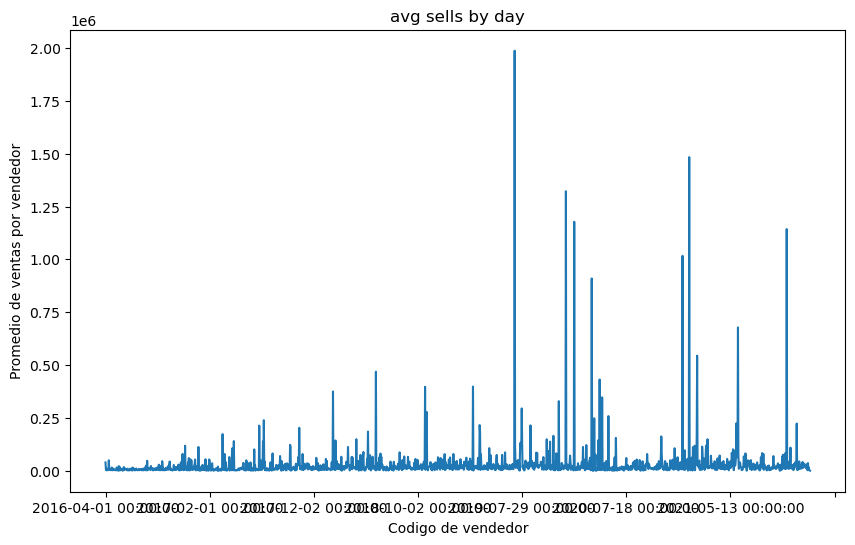

In [ ]:
total_proformas_by_day['avg_by_day'].plot(kind="line", figsize=(10,6), title="avg sells by day")
plt.xlabel("Codigo de vendedor")
plt.ylabel("Promedio de ventas por vendedor")
plt.show()

In [ ]:
len(explore_df[explore_df["Cantidad_vendida"]<0])

2218

In [ ]:
len(explore_df[explore_df["Total_venta"]<0])

2228

In [ ]:
len(explore_df[explore_df["Impuesto"]<0])

2228

In [ ]:
len(explore_df[explore_df["Facturar"]<0])

2228

In [ ]:
len(explore_df[(explore_df["Total_venta"]<0) & (explore_df["Impuesto"])& (explore_df["Facturar"])])

2228

In [ ]:
len(explore_df[explore_df["Total_descuento"]<0])

30

In [ ]:
len(explore_df[explore_df["Total_proforma"]<0])

2221

In [ ]:
len(explore_df[(explore_df["Total_proforma"]<0) & (explore_df["Cantidad_vendida"])])

2221

### Fill df

In [95]:
incompleted_df = explore_df 

Check how many are empty 

In [96]:
incompleted_df = fill_codigo_almacen(incompleted_df)


In [97]:
incompleted_df = fill_codigo_cliente(incompleted_df)

In [ ]:
incompleted_df = fill_nombre_cliente(incompleted_df)

In [98]:
miss_data = show_empty_files(incompleted_df)
miss_data

Codigo_venta            0
Fecha                   0
Codigo_almacen          0
Codigo_cliente          0
Nombre_cliente      -1294
Codigo_vendedor     -9099
Codigo_proyecto    -22535
Codigo_producto         0
Cantidad_vendida        0
Total_proforma          0
Total_descuento         0
Facturar                0
Impuesto                0
Total_venta             0
dtype: int64